## Time to get your hands dirty. Galaxies vs quasars with neural networks.

Let's go back to our galaxy vs quasar data we've used in a previous exercise. 

1. Read in SDSS galaxy color data from `solutions/galaxyquasar.csv`. Create arrays for the $(u-g)$, $(g-r)$, $(r-i)$, and $(i-z)$ colors. Also create an array with the class labels where galaxy=$0$ and quasar=$1$. 

2. Now we're going to fit a neural network classifier. First, scale your data appropriately and do a 30% train/test split.

3. Now train the classifier. Use one the package among those we've seen. These include Tensorflow via keras, pytorch, and the MPL classifier implemented in scikit-learn. This is an opportunity to pick the one you're most interested in learning. 

3. Start from a network architecture with a single hidden layer with 5 neurons, using the `adam` solver, the `relu` activation function, and a learninig rate of `0.001`. Plot the resulting ROC curve. 

4. Now let's optimize the hyperparameters of your network. Explore different hyperparameters and see what fits the data best.  Do your best now to optimize the network architecture. Be creative!

5. Is your best result comparable with the simpler classifiers we've seen before? Do we need deep learning here? If yes, which features are captured best?


A few tips:

- In scikit-learn, remember that you can utilize all availables cores on your machine with `n_jobs=-1`. Print out the classification score for the training data, and the best parameters obtained by the cross validation.
- If it takes too long, run the hyperparameter optimization on a subset of the training set. Then retrain the full network using the best hyperparameters only.
- On cross validation, for scikit learn we've seen how to use `GridSearchCV` already. For Tensorflow, there's a really cool tool called [Tensorboard](https://www.tensorflow.org/tensorboard)

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
from tensorboard.plugins.hparams import api as hp

### Feature preparing and data preprocessing

In [2]:
df = pd.read_csv("../solutions/galaxyquasar.csv")
df

,u,g,r,i,z,class,z1,zerr
0,18.97213,18.53676,18.58280,18.34936,18.29215,QSO,0.522819,0.000155
1,19.24592,17.47646,16.47817,16.04472,15.68851,GALAXY,0.122846,0.000028
2,19.43536,17.70268,16.91565,16.58327,16.39128,GALAXY,0.000000,0.000000
3,19.31626,18.18312,17.39591,16.94549,16.65395,GALAXY,0.147435,0.000009
4,19.28828,19.11188,18.88937,18.80013,18.49183,QSO,2.011455,0.000631
...,...,...,...,...,...,...,...,...
49995,19.37295,18.12382,17.39886,16.98503,16.70585,GALAXY,0.113016,0.000011
49996,18.52021,16.88262,16.03280,15.56884,15.22454,GALAXY,0.085063,0.000014
49997,18.62718,17.30876,16.87371,16.62399,16.42296,GALAXY,0.054429,0.000008
49998,19.55140,18.27711,17.62101,17.21947,17.03347,GALAXY,0.112571,0.000009


Check whether duplicates are present: since it returns a null vector, there are no duplicates.

In [3]:
df[df.duplicated() == True]

,u,g,r,i,z,class,z1,zerr


Adding columns with colours, obtained from the difference of the magnitudes.

In [4]:
df['u-g'] = df['u']- df['g'] 
df['g-r'] = df['g']- df['r'] 
df['r-i'] = df['r']- df['i']
df['i-z'] = df['i']- df['z']

Assigning unique integers instead of the strings "QSO"-"Galaxy" to help the model understand the labels.

In [5]:
le = LabelEncoder()
# Assign unique integers: 1 QSO, 0 galaxy
df['class'] = le.fit_transform(df['class'] )
labels_class = le.inverse_transform(df['class'] )
class_names = le.classes_
print('Class names: ', class_names)
print('Labels: ', labels_class)

Class names:  ['GALAXY' 'QSO']
Labels:  ['QSO' 'GALAXY' 'GALAXY' ... 'GALAXY' 'GALAXY' 'GALAXY']


Checking if the classes are balanced: in this dataset, we have more galaxies than QSO, therefore there is an unbalance. This can be taken into consideration by inserting in the model a bias. In this case, I avoid adding the bias to then compare the results with a similar model but with the bias added.

In [6]:
neg, pos = np.bincount(df['class'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 50000
    Positive: 7134 (14.27% of total)



In [7]:
initial_bias = np.log([pos/neg])
initial_bias

array([-1.79320688])

Dividing the dataset into training, validation and test set, then scaling the data in order to have mean 0 and variance 1.

In [8]:
scaler = StandardScaler().set_output(transform="pandas")
X_train, X_val, y_train, y_val = train_test_split(df.loc[:, 'u-g':'i-z'], df['class'], test_size=0.3, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=9)
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

### Hyperparameters optimization

Here, I load Tensorboard in order to optimize the hyperparameters that will be used into the model. In particular, I checked different values for the number of neurons, the dropout term and the optimizer chosen for the model. To study which combination of hyperparameters give me the best result, I let the model training for 1 epoque and studied the "binary-crossentropy" metric. Finally, I chose the best model as the one who returned me the minimal value for the metric.

In [22]:
%load_ext tensorboard

In [10]:
HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete([5,10,15,20]))
HP_DROPOUT = hp.HParam('dropout', hp.Discrete([0.1, 0.2, 0.5]))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['nadam', 'sgd']))
METRIC_F1SCORE = 'f1_score'

with tf.summary.create_file_writer('no_bias_f1_score/hparam_tuning').as_default():
  hp.hparams_config(
    hparams=[HP_NUM_UNITS, HP_DROPOUT, HP_OPTIMIZER],
    metrics=[hp.Metric(METRIC_F1SCORE, display_name='f1_score')]
  )

In [11]:
def validate_model(hparams):
  model = keras.Sequential([
      keras.layers.InputLayer(shape = (X_train.shape[-1],)),
      keras.layers.Dense(
          hparams[HP_NUM_UNITS], activation='relu',),
      keras.layers.Dropout(hparams[HP_DROPOUT]),
      keras.layers.Dense(1, activation='sigmoid'),
  ])

  model.compile(
      optimizer=hparams[HP_OPTIMIZER],
      loss=keras.losses.BinaryCrossentropy(),
      metrics=[tf.keras.metrics.F1Score(name = 'f1_score', threshold = 0.5)])
  model.fit(X_train_scaled, y_train, epochs=1)
  _, F1score = model.evaluate(X_val_scaled, y_val)
  return (F1score)

In [12]:
def run(run_dir, hparams):
  with tf.summary.create_file_writer(run_dir).as_default():
    hp.hparams(hparams)  # record the values used in this trial
    F1_score = validate_model(hparams)
    tf.summary.scalar(METRIC_F1SCORE, F1_score, step=1)

In [13]:
session_num = 0

for num_units in HP_NUM_UNITS.domain.values:
  for dropout_rate in (HP_DROPOUT.domain.values):
    for optimizer in HP_OPTIMIZER.domain.values:
      hparams = {
          HP_NUM_UNITS: num_units,
          HP_DROPOUT: dropout_rate,
          HP_OPTIMIZER: optimizer,
      }
      run_name = "run-%d" % session_num
      print('--- Starting trial: %s' % run_name)
      print({h.name: hparams[h] for h in hparams})
      run('no_bias_f1_score/hparam_tuning/' + run_name, hparams)
      session_num += 1

--- Starting trial: run-0
{'num_units': 5, 'dropout': 0.1, 'optimizer': 'nadam'}
875/875 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - f1_score: 0.5645 - loss: 0.5198
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - f1_score: 0.9283 - loss: 0.1482
--- Starting trial: run-1
{'num_units': 5, 'dropout': 0.1, 'optimizer': 'sgd'}
875/875 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - f1_score: 0.4200 - loss: 0.5447
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - f1_score: 0.9159 - loss: 0.2090
--- Starting trial: run-2
{'num_units': 5, 'dropout': 0.2, 'optimizer': 'nadam'}
875/875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - f1_score: 0.4607 - loss: 0.5996
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - f1_score: 0.9029 - loss: 0.2275
--- Starting trial: run-3
{'num_units': 5, 'dropout': 0.2, 'optimizer': 'sgd'}
875/875 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - f1_score: 0.5735 - loss: 0.5254
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - f1_score: 0.9351 - loss: 0.1818
--- Starting trial: run-4
{'num_units': 5, 'dropout': 0.5, 'optimizer': 'nadam'}

In [25]:
%tensorboard --logdir no_bias_f1_score/hparam_tuning --host localhost --port 8355

From tensorboard, I get as the best combination the following:

In [9]:
tuned_num_units = 20
tuned_dropout = 0.1
tuned_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

### Model training

Now, I create the multi layer perceptron that I will train to identify QSO. I use as metrics the binary crossentropy, the binary accuracy and the precision, and the binary crossentropy also as the loss function to minimize. I then recreate the model by selecting the tuned hyperparameters for each case.

In [10]:
METRICS = [
      keras.metrics.F1Score(name = 'f1_score', threshold = 0.5),
      keras.metrics.BinaryCrossentropy(name='cross entropy'),  # same as model's loss
      keras.metrics.BinaryAccuracy(name='binary accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name = 'recall'),
]

def make_model(metrics=METRICS):
  model = keras.Sequential([
      keras.layers.InputLayer(shape = (X_train.shape[-1],)),
      keras.layers.Dense(
          tuned_num_units, activation='relu'),
      keras.layers.Dropout(tuned_dropout),
      keras.layers.Dense(1, activation='sigmoid'),
  ])

  model.compile(
      optimizer=tuned_optimizer,
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)
  print(metrics)
  return model

In [11]:
model = make_model()
model.summary()

[<F1Score name=f1_score>, <BinaryCrossentropy name=cross entropy>, <BinaryAccuracy name=binary accuracy>, <Precision name=precision>, <Recall name=recall>]


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 20)                  │             100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 20)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              21 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 121 (484.00 B)

 Trainable params: 121 (484.00 B)

 Non-trainable params: 0 (0.00 B)

Finally, I fit the model on my training data (scaled) and validate it with the validating data (scaled) for 20 epoques.

In [12]:
history = model.fit(X_train_scaled, y_train, epochs=20, validation_data=(X_val_scaled, y_val))

Epoch 1/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - binary accuracy: 0.9271 - cross entropy: 0.3538 - f1_score: 0.8001 - loss: 0.3538 - precision: 0.7344 - recall: 0.8982 - val_binary accuracy: 0.9817 - val_cross entropy: 0.0919 - val_f1_score: 0.9362 - val_loss: 0.0919 - val_precision: 0.9540 - val_recall: 0.9191
Epoch 2/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - binary accuracy: 0.9814 - cross entropy: 0.0882 - f1_score: 0.9343 - loss: 0.0882 - precision: 0.9526 - recall: 0.9168 - val_binary accuracy: 0.9823 - val_cross entropy: 0.0802 - val_f1_score: 0.9384 - val_loss: 0.0802 - val_precision: 0.9542 - val_recall: 0.9232
Epoch 3/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - binary accuracy: 0.9805 - cross entropy: 0.0840 - f1_score: 0.9302 - loss: 0.0840 - precision: 0.9490 - recall: 0.9122 - val_binary accuracy: 0.9827 - val_cross entropy: 0.0783 - val_f1_score: 0.9402 - val_loss: 0.0783 - val_precision: 0.9505 - val_recall: 0.9301
Epoch 4/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms

### Model evaluating

After I trained the model, I save the predictions on the various subsets to analyze the performance of my model.

In [13]:
train_predictions = model.predict(X_train_scaled)
val_predictions = model.predict(X_val_scaled)
test_predictions = model.predict(X_test_scaled)

875/875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step  
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


I create a function to print a 2D confusion matrix as a figure

In [14]:
def plot_cm(labels, predictions, threshold=0.5):
  cm = confusion_matrix(labels, predictions > threshold)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix with threshold = {:.2f}'.format(threshold))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Galaxies correctly detected as galaxies (True Positives): ', cm[0][0])
  print('Galaxies mistakely detected as QSO (False Positives): ', cm[0][1])
  print('QSO mistakely detected as galaxies (False Negatives): ', cm[1][0])
  print('QSO  correctly detected as QSO (True Negatives): ', cm[1][1])
  print('Total galaxies: ', np.sum(cm[0]))
  print('Total QSO: ', np.sum(cm[1]))

First, I evaluate the loss of my model on the validation data. Then, I test the model to compute the confusion matrix associated with the validation data.

loss :  0.0700884461402893
compile_metrics :  0.9446494579315186

Galaxies correctly detected as galaxies (True Positives):  12712
Galaxies mistakely detected as QSO (False Positives):  100
QSO mistakely detected as galaxies (False Negatives):  140
QSO  correctly detected as QSO (True Negatives):  2048
Total galaxies:  12812
Total QSO:  2188


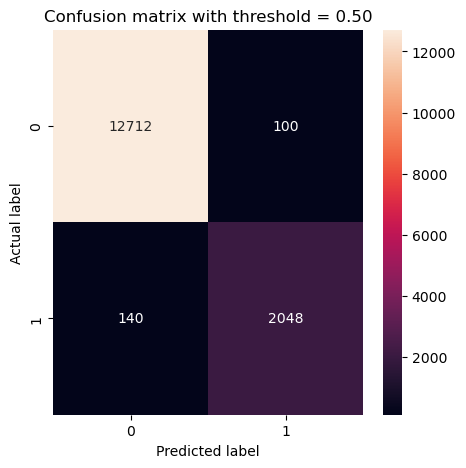

In [15]:
val_results = model.evaluate(X_val_scaled, y_val, verbose=0)
for name, value in zip(model.metrics_names, val_results):
  print(name, ': ', value)
print()

plot_cm(y_val, val_predictions, threshold = 0.5)

Subsequently, I did the same for my test subset.

loss :  0.07157166302204132
compile_metrics :  0.9369553923606873

Galaxies correctly detected as galaxies (True Positives):  5963
Galaxies mistakely detected as QSO (False Positives):  45
QSO mistakely detected as galaxies (False Negatives):  78
QSO  correctly detected as QSO (True Negatives):  914
Total galaxies:  6008
Total QSO:  992


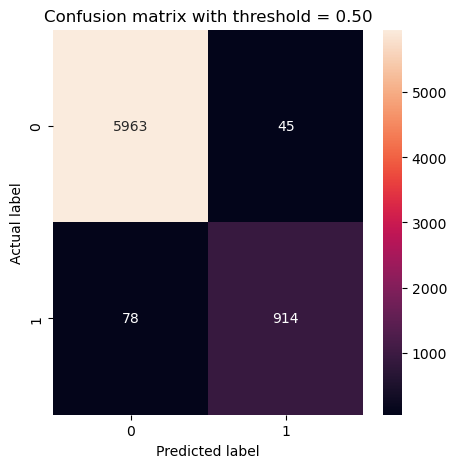

In [16]:
test_results = model.evaluate(X_test_scaled, y_test, verbose=0)
for name, value in zip(model.metrics_names, test_results):
  print(name, ': ', value)
print()

plot_cm(y_test, test_predictions, threshold = 0.5)

Finally, I used the history of my model to compute the metric performances and the loss of my model at each epoque.

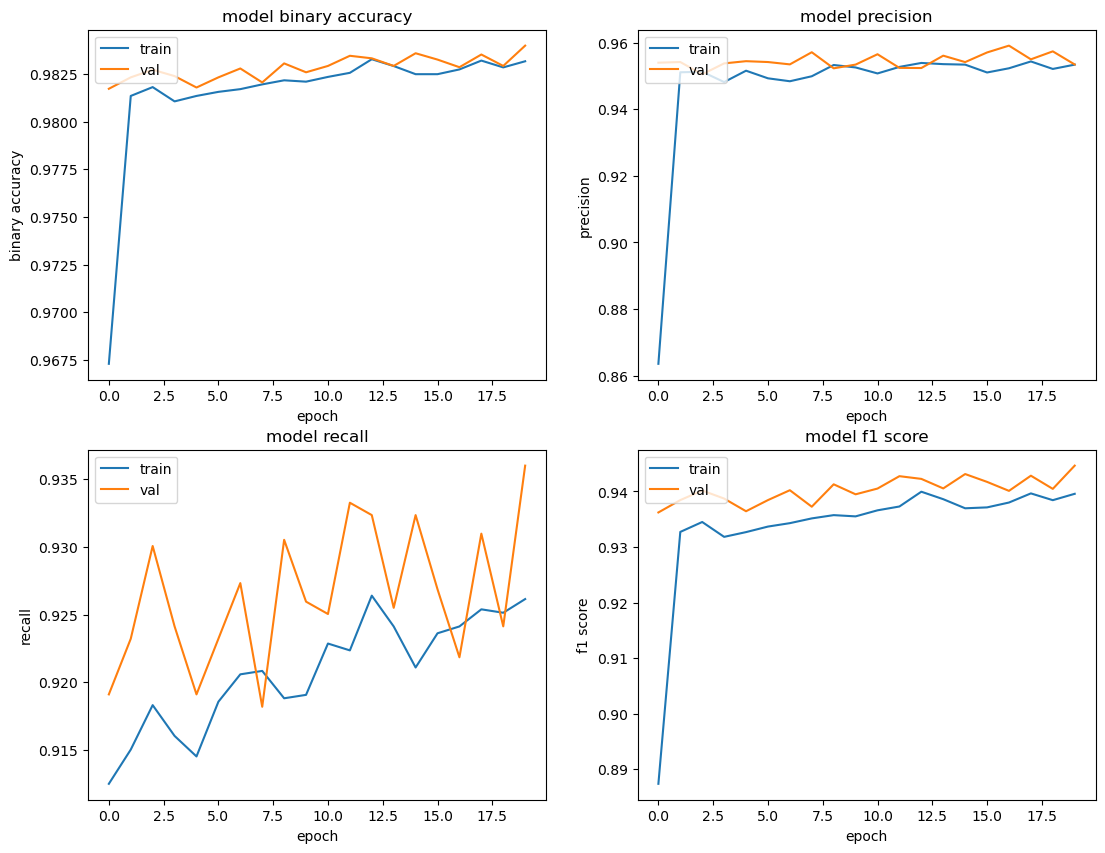

In [17]:
fig = plt.figure(figsize = (13,10))
ax = fig.add_subplot(221)
ax.plot(history.history['binary accuracy'])
ax.plot(history.history['val_binary accuracy'])
ax.set_title('model binary accuracy')
ax.set_ylabel('binary accuracy')
ax.set_xlabel('epoch')
ax.legend(['train', 'val'], loc='upper left')

ax1 = fig.add_subplot(222)
ax1.plot(history.history['precision'])
ax1.plot(history.history['val_precision'])
ax1.set_title('model precision')
ax1.set_ylabel('precision')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'val'], loc='upper left')

ax3 = fig.add_subplot(223)
ax3.plot(history.history['recall'])
ax3.plot(history.history['val_recall'])
ax3.set_title('model recall')
ax3.set_ylabel('recall')
ax3.set_xlabel('epoch')
ax3.legend(['train', 'val'], loc='upper left')
epoque = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]

ax2 = fig.add_subplot(224)
ax2.plot(history.history['f1_score'])
ax2.plot(history.history['val_f1_score'])
ax2.set_title('model f1 score')
ax2.set_ylabel('f1 score')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'val'], loc='upper left')
plt.show()

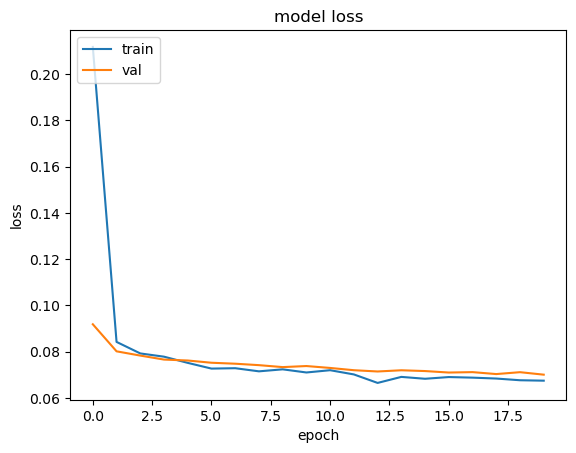

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Here, I print the report of the performance of my model on the test subset.

In [19]:
from sklearn.metrics import classification_report

report = classification_report(y_test, model.predict(X_test_scaled) > 0.5)
print(report)   

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      6008
           1       0.95      0.92      0.94       992

    accuracy                           0.98      7000
   macro avg       0.97      0.96      0.96      7000
weighted avg       0.98      0.98      0.98      7000



Finally, I also add the ROC curve for the model.

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


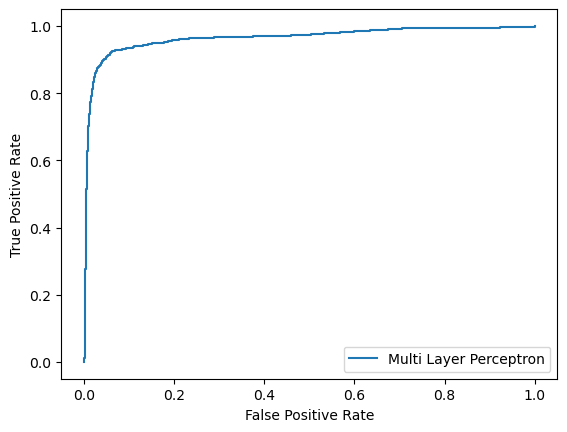

In [20]:
fpr, tpr, threshold = roc_curve(y_test, model.predict(X_test))
RocCurveDisplay(fpr=fpr, tpr=tpr, estimator_name = 'Multi Layer Perceptron').plot();

### Bonus Section

We can see whether the use of a multi layer perceptron for this dataset is justified in comparison with the classifier studied in L19, by comparing the confusion matrices. To be sure that the same values are in the training and testing sets, I used the same random states with which I divide them here.

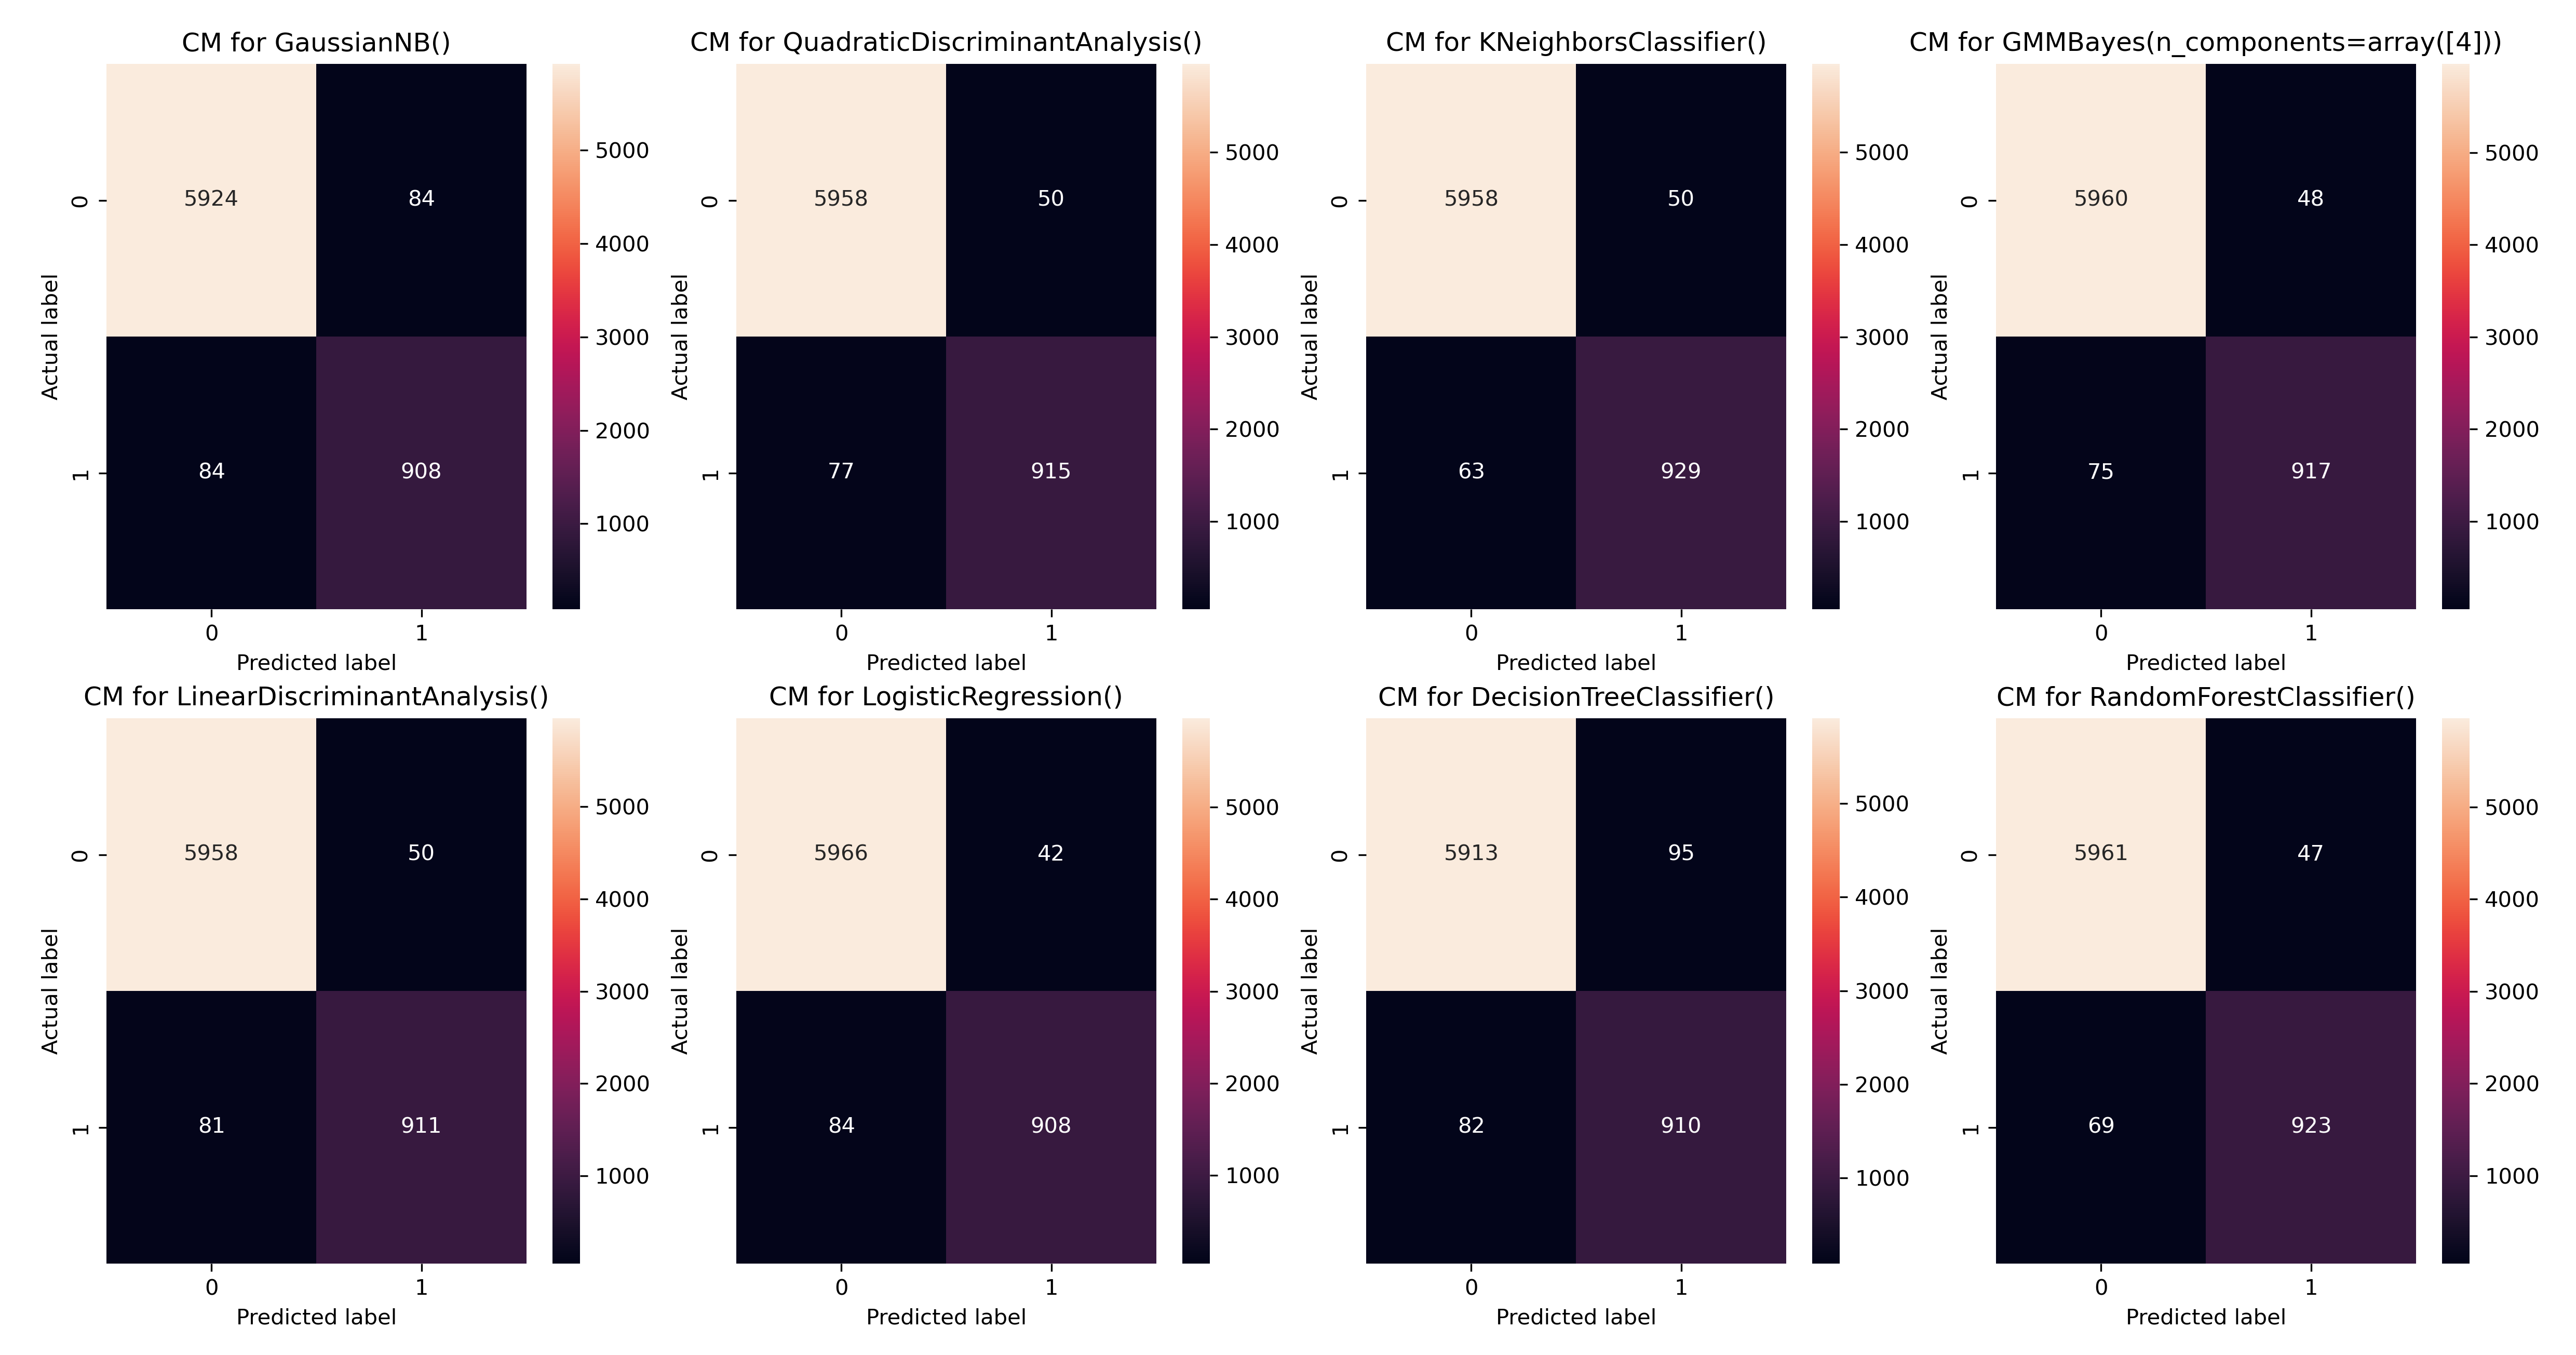

In [3]:
from IPython.display import Image
Image('confusion matrices.png')

Comparing them with the one obtained from the Multi Layer Perceptron, we can notice that its implementation is basically an overkill for this dataset, since other models - such as the KneighborsClassifier and the RandomForestClassifier are able to reach even better results. One could increase the complexity of the multi layer perceptron, but we have to take into account that I didn't even do any cross validation on the classifiers to reach the same results.